In [215]:
import os,sys
ROOT_DIR = os.path.abspath("../../")
INTERIM_DATA = os.path.join(ROOT_DIR, 'data/interim')
PROCESSED_DATA = os.path.join(ROOT_DIR, 'data/processed')
txt = os.path.join(ROOT_DIR, 'data/processed/keep_img_ids.txt')
sys.path.append(ROOT_DIR)  # To find local version of the library

import shutil
from sklearn.metrics import jaccard_score
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import json
from skimage.draw import polygon
import helper as hp
import skimage.transform as st

from models.maskrcnn.mrcnn import visualize,utils

IMG_DIR = os.path.join(PROCESSED_DATA, 'images')
LBL_DIR = os.path.join(PROCESSED_DATA, 'segmentations')

keeplabels ={'sidewalk':8,
            'rail track':10,
            'wall':12,
            'fence':13,
            'guard rail':14,
            'pole':17,
            'polegroup':18,
            'vegetation': 21,
            'car':26,
            'bicycle':33}
inv_keeplabels =  {
    8: 'sidewalk',
    10: 'rail track',
    12: 'wall',
    13: 'fence',
    14: 'guard rail',
    17: 'pole',
    18:  'polegroup',
    21: 'vegetation',
    26: 'car',
    33: 'bicycle'}


In [24]:
# labels ={'sidewalk':8,
#             'rail track':10,
#             'wall':12,
#             'fence':13,
#             'guard rail':14,
#             'pole':17,
#             'polegroup':18,
#             'traffic sign': 20,
#             'vegetation': 21,
#             'car':26}

# IMG_DIR = os.path.join(INTERIM_DATA, 'leftImg8bit')
# LBL_DIR = os.path.join(INTERIM_DATA, 'gtFine/')

# x_train, y_train = IMG_DIR + '/train', LBL_DIR+'train'
# # x_test, y_test = IMG_DIR + '/test', LBL_DIR+'/test'
# x_val , y_val =IMG_DIR + '/val', LBL_DIR+'val'

In [25]:
# with open(txt,'r') as f:
#     keep_ids = f.readlines()
#     keep_ids = [k[:-1] for k in keep_ids]

In [26]:
# # shutil.move('oldname', 'renamedfiles/newname')
# # moving everything one level up 
# def moveUp(old_directory, new_directory=None, to_keep = None, mask=False):
#     for cities in os.listdir(old_directory):
#         subdir = os.path.join(old_directory,cities)
#         if cities == '.DS_Store':
#             continue
#         for img in os.listdir(subdir):
#             _id = img.split('.')
#             if mask and _id[1]!='json':
#                 continue
#             id = "_".join(_id[0].split("_")[:3])
#             if id in to_keep:
#                 img_path = os.path.join(subdir,img)
#                 if mask:
#                     new_path = os.path.join(new_directory,'segmentations',f'{id}.json')
#                 else:
#                     new_path = os.path.join(new_directory,'images',f'{id}.json')
                
#                 shutil.move(img_path, new_path)         

# # moveUp(x_train, PROCESSED_DATA, keep_ids)
# # moveUp(x_val, PROCESSED_DATA, keep_ids)
# # moveUp(y_train, PROCESSED_DATA, keep_ids,True)
# # moveUp(y_val, PROCESSED_DATA, keep_ids, True)


In [27]:
# check correct number of items moved
# len(os.listdir(PROCESSED_DATA+'/images')) ==len(os.listdir(PROCESSED_DATA+'/segmentations'))

In [28]:
# def getInstances(filename:str, labelsToKeep:dict):
#     labels = ''
#     # labels = []
#     keys = labelsToKeep.keys()
#     data = json.load(open(filename))
#     data = data["objects"]
#     for d in data:
#         l = d['label']
#         if l in keys:
#             # labels.append(labelsToKeep[l])
#             labels += str(labelsToKeep[l])+' '
#     return labels

# def getLabels(ids, y_directory,keepLabels=labels):
#     labels = []
#     for id in ids:
#         # city= id.split('_')[0]
#         # im_path = os.path.join(x,city,id+'_leftImg8bit.png')
#         lb_path = os.path.join(y_directory, id+'.json')
#         labels.append(getInstances(lb_path,keepLabels))
#     return labels

# import pandas as pd
# def generateCSV(filepath:str, ids, labels):
#     df = pd.DataFrame(data=list(zip(ids, labels)),columns=['ID','LABEL'])
#     df.to_csv(filepath, index=False)

In [29]:
# generate Id, label pair
# labels = getLabels(keep_ids,LBL_DIR)
# generateCSV(os.path.join(PROCESSED_DATA,'labels.csv'),keep_ids,labels)

In [30]:
from typing import Union

# labels ={'sidewalk':8,
#             'rail track':10,
#             'wall':12,
#             'fence':13,
#             'guard rail':14,
#             'pole':17,
#             'polegroup':18,
#             'traffic sign': 20,
#             'vegetation': 21,
#             'car':26}

# def parse_json(filename: str, keep:Union[tuple,list,dict]=labels, return_labels = False, int_labels=False):
#     polygons = []
#     label_n_polygons = {}
#     with open(filename) as f:
#         data = json.load(f)
#         im_h, im_w = data['imgHeight'], data['imgWidth']
#         objects = data["objects"]
#         for i in objects:
#             # print(i['label'])
#             lab = i['label']
#             if lab in keep:
#                 poly_coords = i['polygon']
#                 tmp = list(zip(*poly_coords))
#             # NOTE: The following line assumes that the point coordinates are given as (x,y). 
#             #       Change the order of the indices if needed.

#                 # polygons.append((np.array(tmp[1])-1, np.array(tmp[0])-1))
#                 polygons.append((np.array(tmp[0]), np.array(tmp[1])))
#                 if return_labels:
#                     if int_labels:
#                         lab = keep[lab]
#                     if lab not in label_n_polygons:
#                         label_n_polygons[lab] = []
#                     label_n_polygons[lab].append(tmp)
#     # return (im_h, im_w), labels, polygons
#     if return_labels:
#         return (im_h,im_w), label_n_polygons
    
#     return (im_h, im_w), polygons

# # https://stackoverflow.com/questions/72168663/setting-a-list-of-x-y-cooordinates-into-an-array-so-polygons-are-drawn
# def draw_instance_Mask(img,poly):
    
#     r = poly[0]
#     c = poly[1]
#     r_index, c_index = polygon(r, c)
#     r_index, c_index = np.clip(r_index,0,img.shape[1]-1),np.clip(c_index,0,img.shape[0]-1)
#     # print(type(r_index),max(r_index),max(c_index))

#     # r_index = [i if i <imgsize[0] else imgsize[0]-1 for i in r_index]
#     # c_index = [i if i <imgsize[1] else imgsize[1]-1 for i in c_index]
#     # new_index = max(0, min(new_index, len(mylist)-1))

#     img[c_index,r_index] = 1
#     # return img


# def draw_flat_mask(img, polygons):
#     for poly in polygons:
#         if isinstance(polygons, dict):
#             ps = polygons[poly]
#             for p in ps:
#                 draw_instance_Mask(img, p)
#         else:
#             draw_instance_Mask(img, poly)



In [31]:
# dim, polys = parse_json(LBL_DIR+'/bremen_000217_000019.json',return_labels=True)
# im = np.zeros(dim, dtype=np.uint8)
# draw_flat_mask(im, polys)
# plt.imshow(im)

# print('labels in this image:')
# for p in polys:
#     print(p)

# Testing Flat IOUs

In [32]:
# s_pole = {'sidewalk':polys['sidewalk'],
#           'pole': polys['pole']}
# im = np.zeros(dim, dtype=np.uint8)
# draw_flat_mask(im, s_pole)
# plt.imshow(im)

In [33]:
# im = np.zeros(dim)
# draw_flat_mask(im, polys['pole'])
# plt.imshow(im)

In [34]:
# from sklearn.metrics import jaccard_score

# sidewalk_mask = np.zeros(dim, dtype=np.uint8)
# draw_flat_mask(sidewalk_mask, polys['sidewalk'])

# wall_mask = np.zeros(dim, dtype=np.uint8)
# draw_flat_mask(wall_mask, polys['vegetation'])


# jac = jaccard_score(sidewalk_mask,wall_mask, average='micro')
# print(jac)

# s_pole = {'sidewalk':polys['sidewalk'],
#           'vegetation': polys['vegetation']}
# im = np.zeros(dim, dtype=np.uint8)
# draw_flat_mask(im, s_pole)
# plt.imshow(im)

In [35]:
# car_mask = np.zeros(dim, dtype=np.uint8)
# draw_flat_mask(car_mask, polys['car'])


# jac = jaccard_score(sidewalk_mask,car_mask, average='micro')
# print(jac)

# s_car = {'sidewalk':polys['sidewalk'],
#           'car': polys['car']}
# im = np.zeros(dim, dtype=np.uint8)
# draw_flat_mask(im, s_car)
# plt.imshow(im)

In [36]:
# im = np.zeros(dim)
# draw_flat_mask(im, polys['sidewalk'])
# plt.imshow(im)

# Labeling IOUs

```for all 3277 pics
for all class, generate each instances of mask
    taken care of with the polygon json processing
for each mask, label them 
    id_class_instance-num e.g.
        aachen_000003_000019_sidewalk_001
        aachen_000003_000019_car_001
        ...
    if there are 10 labels: 3 of them sidewalk and 7 of them not sidewalk
        the data for the classifer will be something like
          img-id_sidewalk_instance-id   |   img-id_class_instance-id   |   IOU (not read but calculated)    |  label
```


In [4]:
df = pd.read_csv(os.path.join(PROCESSED_DATA,'labels.csv'),index_col=None)
df.head()
data = df.set_index('ID').T.to_dict('list')
for k in data:
    data[k] = [i.split(' ')[:-1] for i in data[k]][0]
    data[k] = np.array([int(i) for i in data[k]])

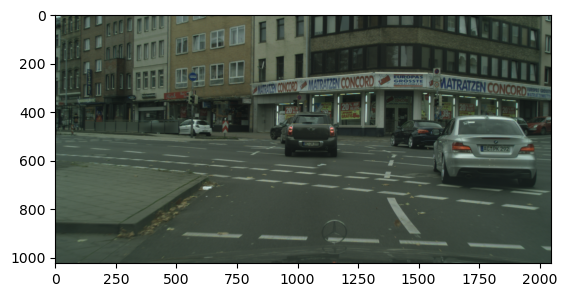

In [3]:
x= plt.imread(IMG_DIR+'/aachen_000003_000019.png')
# x = st.resize(x,(256,512))
plt.imshow(x)

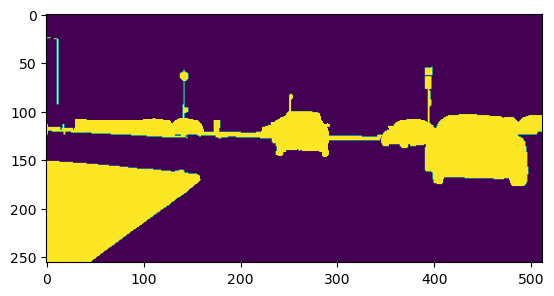

In [4]:
dim = (256,512)
d, polys_x = hp.parse_json(LBL_DIR+'/aachen_000003_000019.json',return_labels=True, int_labels=True,resize=dim)
img = np.zeros(d)
hp.draw_flat_mask(img, polys_x)
plt.imshow(img)

# creating `.npy` files
```
for f in os.listdir(IMG_DIR):
        img_dim, label_polydict = parse_json(f)
        masks = []      # order the masks the same way it's listed in labels.csv
        
        
```


In [39]:
# # read the dataframe then store it as a dictionary with id as keys and labels as values 
# df = pd.read_csv(os.path.join(PROCESSED_DATA,'labels.csv'),index_col=None)
# df.head()
# data = df.set_index('ID').T.to_dict('list')
# for k in data:
#     data[k] = [i.split(' ')[:-1] for i in data[k]][0]
#     data[k] = np.array([int(i) for i in data[k]])

# # stack all the masks in the order of the labels read 
# def stack_mask(id, data,dir=LBL_DIR):
#     labels = data[id]
#     im_dim, polygons = parse_json(dir+f'/{id}.json', return_labels=True, int_labels=True)
#     key_count = {}
#     masks = []
#     for label in labels:
#         if label not in key_count:
#             key_count[label]=0
#         count = key_count[label]
#         mask = polygons[label][count]
#         img = np.zeros(im_dim, dtype=np.uint8)
#         draw_instance_Mask(img,mask)
#         masks.append(img)
#         key_count[label]+=1
    
#     masks = np.stack(masks, axis=-1)
#     return masks

In [243]:
txt = os.path.join(ROOT_DIR, 'data/processed/sample.txt')
with open(txt) as f:
    sample_ids= f.readlines()
sample_ids = [i.strip('\n').split('.')[0] for i in sample_ids]  # select a small sample of ids

# generate all labels for each sample
sample_labels = [data[id] for id in sample_ids]

data_mask = {}
for id in sample_ids:
    masks = hp.stack_mask(id, data,(256,512))
    data_mask[id] = masks
    # np.save(os.path.join(PROCESSED_DATA,'masks',f'{id}.npy'),masks)

In [247]:
i = 72
dim = (256,512)
labels_dict = {'sidewalk':8,
            'rail track':10,
            'wall':12,
            'fence':13,
            'guard rail':14,
            'pole':17,
            'polegroup':18,
            'vegetation': 21,
            'car':26,
            'bicycle':33}


m1 = data_mask[sample_ids[i]]
y1 = sample_labels[i]
names = [labels_dict[y]for y in y1]

img = plt.imread(f'{IMG_DIR}/{sample_ids[i]}.png')
img = st.resize(img, dim)

aa = np.array(y1)
bboxes= utils.extract_bboxes(m1)
bboxes_w_ids = np.zeros((bboxes.shape[0],bboxes.shape[1]+1))
bboxes_w_ids[:,:-1]=bboxes
bboxes_w_ids[:,-1]= aa

# captions = [str(i)+': '+str(labels_dict[y1[i]]) for i in range(len(y1))]



In [248]:
def generate_ious(labels, masks,sidewalk_lbl=8, IOU_THRESHOLD=0):
    sidewalk_idx = np.where(labels==sidewalk_lbl)[0]
    # sidewalk_masks = masks[:,:, sidewalk_idx]

    all_labels = np.unique(labels)
    ious = {}

    for label in all_labels:
        if label == sidewalk_lbl: continue
        for sidewalk in sidewalk_idx:
            sidewalk_mask = masks[:,:,sidewalk]
            non_sidewalk = np.where(labels==label)[0]
            for i in non_sidewalk:
                iou = jaccard_score(sidewalk_mask, masks[:,:,i],average='micro',zero_division={0.0, 1.0})
                if iou > IOU_THRESHOLD:
                    if i not in ious:
                        ious[i] = (sidewalk, iou)
                    else:
                        if ious[i][-1] < iou:
                            ious[i] = (sidewalk,iou)
    return ious


def generate_captions_obstructed(labels, ious, labels_dict=inv_keeplabels):
    captions = []
    for i in range(len(labels)):
        tmp = ''
        if i in ious: 
            tmp += f'{i} {labels_dict[labels[i]]}'
            sidewalk, iou = ious[i]
            tmp += f'({sidewalk}) {round(iou,3)}'
        captions.append(tmp)
    return captions
        


In [249]:
ious = generate_ious(y1, m1)
# captions = []
# for i in range(len(y1)):
#     tmp = ''
#     if y1[i]==8:
#         tmp += f'{i} sidewalk'
#     if i in ious:
#         tmp += f'{i} {labels_dict[y1[i]]}'
#         sidewalk, iou = ious[i]
#         tmp += f' {round(iou,3)}'

#     captions.append(tmp)

# # captions
captions = generate_captions_obstructed(y1, ious)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


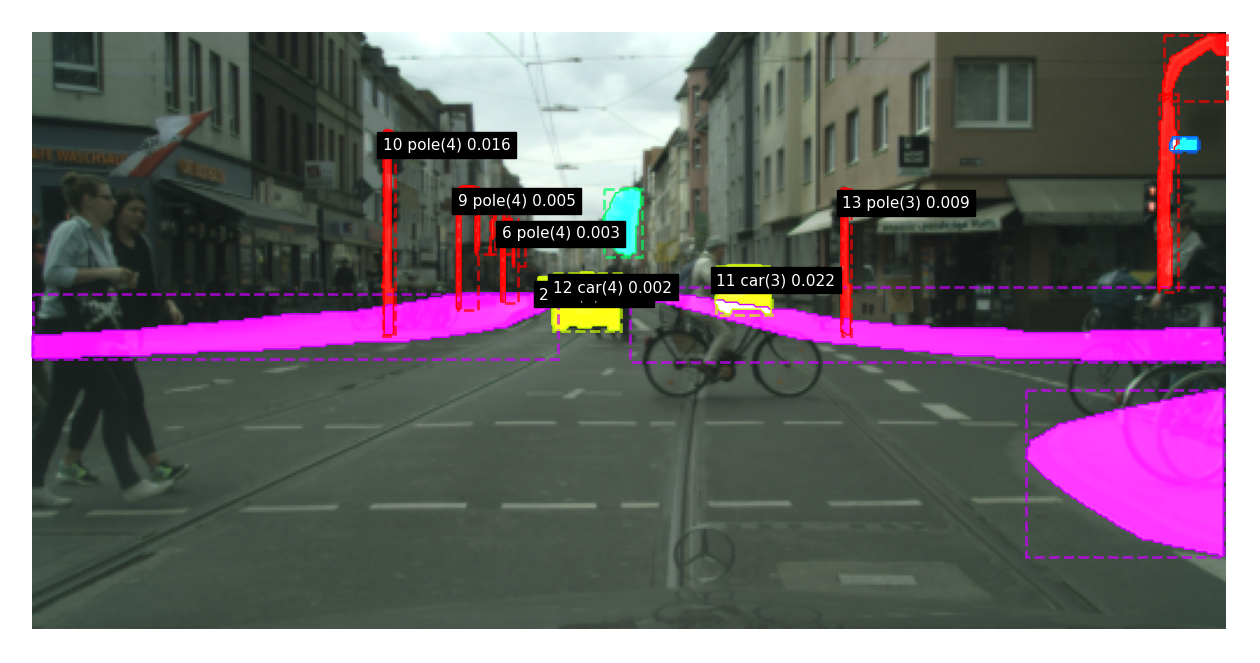

In [250]:
visualize.display_instances(img,bboxes,m1,y1,labels_dict, captions=captions)

# IDK

In [178]:
# for ious we can get the maximum of all the three ?
s_idx = np.where(y1==8)[0]      #sideaposition
sidewalks=m1[:,:,s_idx]

all_labs = np.unique(y1)
ious = {}

for lab in all_labs:   # for all labels
    if lab ==8:
        continue
    for i in s_idx: # for sidewalk in sidewalks
        for l in np.where(y1==lab)[0]:      # for nonsidewalk in nonsideawalks
            # calculate iou
            iou = jaccard_score(m1[:,:,i],m1[:,:,l],average='micro',zero_division={0.0, 1.0})
            if iou>0:
                if l not in ious:
                    ious[l] = (i,iou)
                    # print(l,iou, ious[l][-1])
                else:
                    if ious[l][-1]<iou:
                        ious[l] = (i,iou)
                         
                        


# ious 
# ious with sparse matrix 
sparse = np.zeros((len(y1),len(y1)))
for sidewalk_idx, value_pair in zip(ious, ious.values()):
    for idx, iou in value_pair:
        sparse[sidewalk_idx,idx] = iou


sparse

TypeError: cannot unpack non-iterable numpy.int64 object

In [175]:
ious = {}

for lab in all_labs:
    if lab ==8:
        continue
    for i in s_idx:
        for l in np.where(y1==lab)[0]:
            # calculate iou
            iou = jaccard_score(m1[:,:,i],m1[:,:,l],average='micro',zero_division={0.0, 1.0})
            if iou>0:
                if l not in ious:
                    ious[l] = []
                
                ious[l].append({i:iou})

In [176]:
ious

{2: [{4: 0.0006132461161079313}],
 17: [{14: 0.08949011446409989}],
 22: [{14: 0.0029354207436399216}, {21: 0.010169491525423728}],
 7: [{4: 0.00020879006159306817}],
 8: [{4: 0.00010451505016722408}],
 9: [{4: 0.0011497857217518553}],
 11: [{4: 0.0021964229683087543}],
 13: [{4: 0.0044689253793390145}],
 26: [{4: 0.0025088856366297305}],
 28: [{4: 0.006019095060190951}],
 18: [{14: 0.013856812933025405}],
 23: [{14: 0.013363028953229399}, {21: 0.00010166734444896299}],
 6: [{4: 0.026464435146443515}],
 10: [{4: 0.01663719659218775}],
 19: [{4: 0.026464435146443515}],
 27: [{4: 0.021900430828147438}],
 5: [{4: 0.0029288702928870294}]}

In [65]:
# from operator import itemgetter   
# def sortIOU(d):
#     for v in d.values():
#         v.sort(key=itemgetter(1))
#     return sorted(d.items())

# s  =sortIOU(ious)

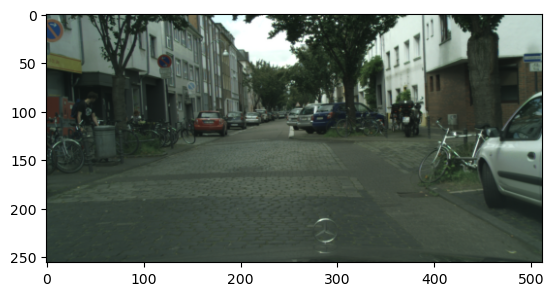

In [63]:
img = plt.imread(f'{IMG_DIR}/{sample_ids[i]}.png')
img = st.resize(img, dim)
plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


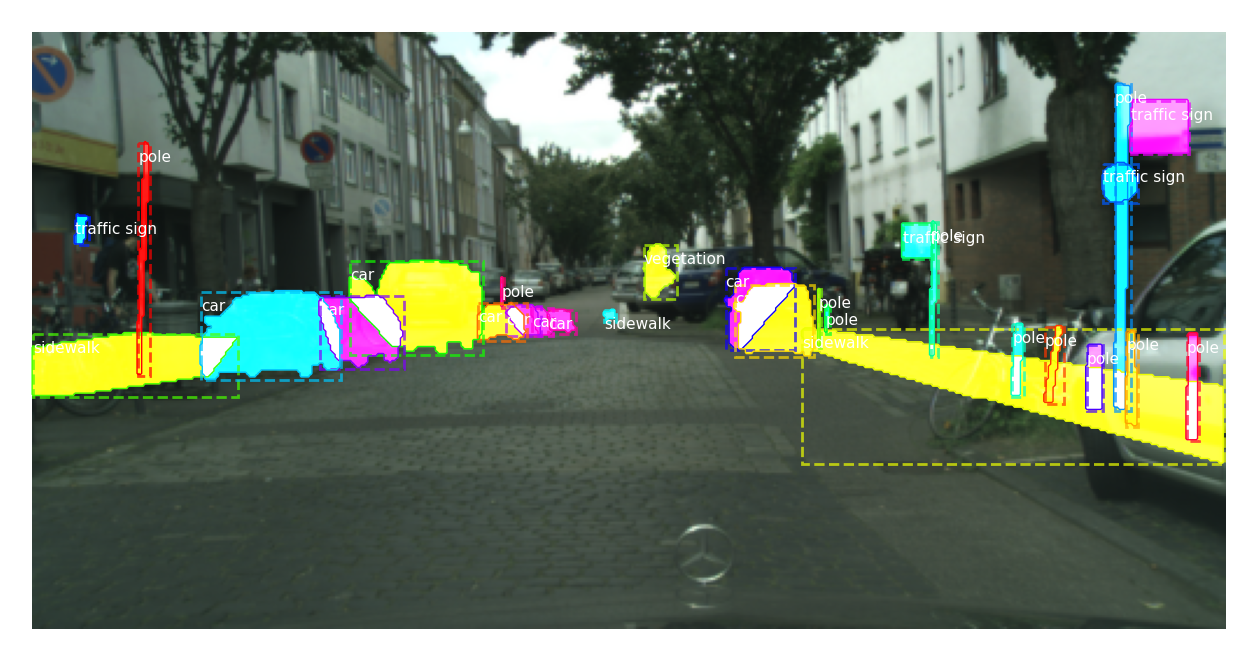

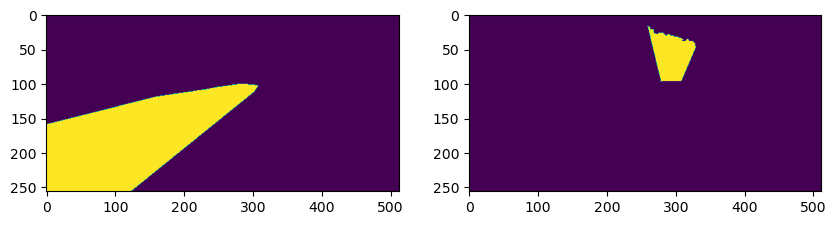

In [56]:
xx = np.stack([m1[:,:,2],m1[:,:,0]],axis=-1)
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(1,2,1)
plt.imshow(xx[:,:,0])
fig.add_subplot(1,2,2)
plt.imshow(xx[:,:,1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


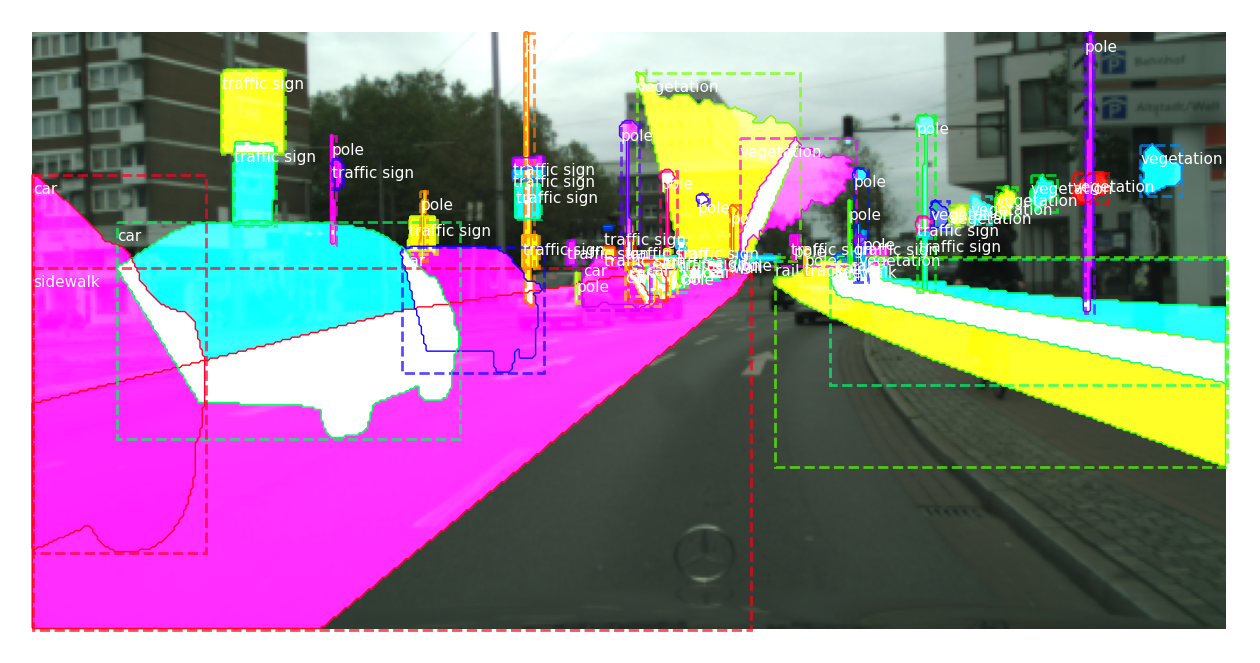

In [27]:
img.shape

(256, 512, 3)

In [ ]:
# instead of for loops
# create a matrix instead and alculate a matrix of ious

In [38]:


a = st.resize(m1[:,:,0],(256,512))

In [ ]:
st.resize(m1)

In [39]:
a.shape,m1[:,:,0].shape

((256, 512), (1024, 2048))